# Volatility Pipeline

## Realized

Steps on an intraday level:

1. Resample the data into the appropriate level of aggregation (e.g. 5min or 15min)
2. Find the log returns intraday
3. Square them
4. Sum them up within each day individually
5. Reorganise the dataframe back to daily level

Steps on a daily level:

1. Upsample to 1D
2. Use mean as the statistical value to take as daily price
3. fill nas

Final steps:

1. Merge

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import math
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
unpickled_df_old = pd.read_pickle("Data/15sec.pkl")
unpickled_df_new = pd.read_pickle("Data/965814_20210801_20211012_index.pkl")
unpickled_df = pd.concat([unpickled_df_old,unpickled_df_new])
daily_old = pd.read_csv("Data/sx5e_daily.csv", sep = ";")
daily_new = pd.read_csv("Data/sx5e_daily_update.csv", sep = ";")
daily = pd.concat([daily_old,daily_new[1022:]])
daily = daily.drop(columns = ["wkn","it_highest_price","it_lowest_price"]).rename(columns={"fact_date": "regional_timestamp"})
daily['regional_timestamp'] = pd.to_datetime(daily['regional_timestamp'],dayfirst=True)
daily = daily.set_index('regional_timestamp')

In [3]:
def resample_timeperiod(df,time):
    df = df.set_index('regional_timestamp').drop('wkn', axis=1).resample(rule = time, closed = 'right',  label = 'right').last()
    return df

In [4]:
five_minutes = resample_timeperiod(unpickled_df,"5T")
fifteen_minutes = resample_timeperiod(unpickled_df,"15T")

In [5]:
def INTRA(df):
    df['intraday_volatility'] = (np.log(df.price) - np.log(df.price.shift(1)))**2
    df.reset_index(level=0, inplace=True)
    df = df.groupby(pd.Grouper(key='regional_timestamp',freq='1D')).sum()
    df1 = df.drop(['price'], axis=1)
    return df1

In [6]:
def OVERNIGHT(df):
    df['Overnight_volatility'] = (np.log(df.it_open_price) - np.log(df.it_close_price.shift(1)))**2
    df1 = df.drop(columns =['it_open_price','it_close_price'])
    return df1

In [7]:
Intraday_vola = INTRA(five_minutes)
Overnight_vola = OVERNIGHT(daily)

In [8]:
Intraday_vola.head(2)
Overnight_vola.head(2)
Intraday_vola.index

,intraday_volatility
regional_timestamp,
2017-01-02,0.000025
2017-01-03,0.000026


,Overnight_volatility
regional_timestamp,
2017-01-02,NaN
2017-01-03,0.000006


DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09',
               '2017-01-10', '2017-01-11',
               ...
               '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06',
               '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10',
               '2021-10-11', '2021-10-12'],
              dtype='datetime64[ns]', name='regional_timestamp', length=1745, freq='D')

In [9]:
Volatility = pd.concat([Intraday_vola, Overnight_vola], axis=1).dropna(axis='index')
#Volatility = Volatility.drop('index', axis=1)
Volatility['Volatility'] = Volatility["intraday_volatility"] +  Volatility["Overnight_volatility"]

In [10]:
Volatility.head(10)

,intraday_volatility,Overnight_volatility,Volatility
regional_timestamp,,,
2017-01-03,0.000026,5.629988e-06,0.000031
2017-01-04,0.000015,2.817231e-07,0.000015
2017-01-05,0.000023,1.145655e-05,0.000035
2017-01-06,0.000032,2.387034e-06,0.000034
2017-01-09,0.000021,9.743988e-07,0.000022
2017-01-10,0.000020,2.515433e-07,0.000020
2017-01-11,0.000046,3.403445e-08,0.000046
2017-01-12,0.000036,6.160134e-06,0.000042
2017-01-13,0.000022,9.377146e-06,0.000031


## Implied

Two proxies:
1. VSTOXX
2. Black Scholes inverted Put and Call vola. Final implied mean of two

In [11]:
VSTOXX = pd.read_csv('Data/VSTOXX_extended.csv',sep=';').rename(columns={"Date": "regional_timestamp","Indexvalue":"Preis"}).drop("Symbol",axis=1)
Black_Scholes = pd.read_csv('Data/Implied_Black.csv')

In [12]:
VSTOXX['regional_timestamp'] = pd.to_datetime(VSTOXX['regional_timestamp'],dayfirst=True)
VSTOXX = VSTOXX.set_index('regional_timestamp')

In [13]:
Black_Scholes = Black_Scholes[['Dates','HIST_CALL_IMP_VOL','HIST_PUT_IMP_VOL']].rename(columns={"Dates": "Regional_timestamp"})

In [14]:
Black_Scholes = Black_Scholes.set_index('Regional_timestamp')

In [15]:
Black_Scholes['Implied_Volatility'] = (Black_Scholes['HIST_CALL_IMP_VOL']+Black_Scholes['HIST_PUT_IMP_VOL'])/2

In [16]:
Black_Scholes.head(10)

,HIST_CALL_IMP_VOL,HIST_PUT_IMP_VOL,Implied_Volatility
Regional_timestamp,,,
1/2/2017,16.77,16.77,16.77
1/3/2017,16.27,16.27,16.27
1/4/2017,15.54,15.54,15.54
1/5/2017,15.01,15.01,15.01
1/6/2017,14.33,14.33,14.33
1/9/2017,14.19,14.19,14.19
1/10/2017,13.91,13.91,13.91
1/11/2017,14.16,14.16,14.16
1/12/2017,14.72,14.72,14.72


In [17]:
VSTOXX.tail(10)

,Preis
regional_timestamp,
2021-11-08,17.1981
2021-11-09,18.0620
2021-11-10,17.1761
2021-11-11,17.0902
2021-11-12,16.1449
2021-11-15,16.6495
2021-11-16,16.7973
2021-11-17,16.6822
2021-11-18,17.7692


In [18]:
Volatility

,intraday_volatility,Overnight_volatility,Volatility
regional_timestamp,,,
2017-01-03,0.000026,5.629988e-06,0.000031
2017-01-04,0.000015,2.817231e-07,0.000015
2017-01-05,0.000023,1.145655e-05,0.000035
2017-01-06,0.000032,2.387034e-06,0.000034
2017-01-09,0.000021,9.743988e-07,0.000022
...,...,...,...
2021-10-06,0.000135,1.514401e-05,0.000150
2021-10-07,0.000034,3.805488e-05,0.000072
2021-10-08,0.000048,8.864066e-08,0.000048


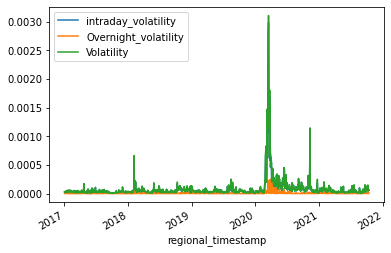

In [19]:
lines = Volatility.plot.line()

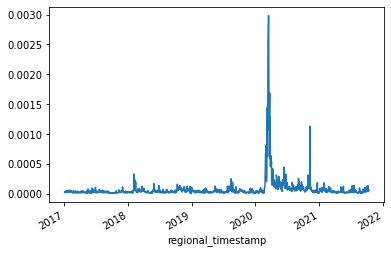

In [20]:
lines2 = Volatility.intraday_volatility.plot.line()

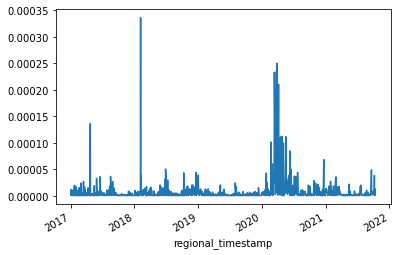

In [21]:
lines2 = Volatility.Overnight_volatility.plot.line()

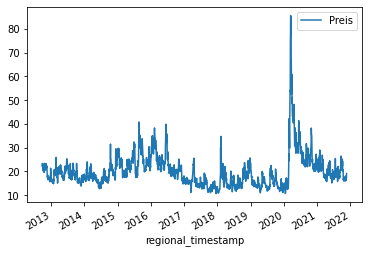

In [22]:
impl = VSTOXX[3500:].plot.line()

ADF test shows we are stationarry

In [23]:
from statsmodels.tsa.stattools import adfuller
X = Volatility["Volatility"]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.896918
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


## Combining Implied and Realized and calculating difference

In [24]:
VSTOXX1 = VSTOXX.loc['2017-01-03':'2021-10-12'] # Cutting into sample size

In [25]:
print("Vstoxx shape : " + str(VSTOXX1.shape))
print("Volatility shape : " + str(Volatility.shape))

Vstoxx shape : (1215, 1)
Volatility shape : (1221, 3)


We see there are just a few rows more in Volatility than VSTOXX. Probably some holidays , let's check

In [26]:
Volatility[~Volatility.index.isin(VSTOXX1.index)]

,intraday_volatility,Overnight_volatility,Volatility
regional_timestamp,,,
2018-12-24,0.000007,5.707478e-06,0.000013
2018-12-31,0.000004,2.654706e-06,0.000007
2019-12-24,0.000001,4.490723e-07,0.000002
2019-12-31,0.000002,2.463391e-07,0.000002
2020-12-24,0.000004,1.027836e-06,0.000005
2020-12-31,0.000010,2.714857e-06,0.000012


We see these are the pre christmas and newyear days. Will just drop them from Volatility and concat the remaining part of the DF

In [27]:
Volatility1 = Volatility.drop(Volatility.index[~Volatility.index.isin(VSTOXX1.index)])

In [28]:
print("Vstoxx shape : " + str(VSTOXX1.shape))
print("Volatility shape : " + str(Volatility1.shape))

Vstoxx shape : (1215, 1)
Volatility shape : (1215, 3)


In [29]:
Volatility1.head(1)

,intraday_volatility,Overnight_volatility,Volatility
regional_timestamp,,,
2017-01-03,0.000026,0.000006,0.000031


Normalizing the VSTOXX which is anualized to a yearly level.

In [30]:
VSTOXX1["Preis_Norm"] = VSTOXX1["Preis"] #/ np.sqrt(252) # Change with / np.sqrt()
VSTOXX1 = VSTOXX1.drop(columns = "Preis")

In [31]:
Volatility_combined = pd.concat([Volatility1, VSTOXX1], axis=1).dropna(axis='index')

Taking care of the scale: 

1. Volatility is the square root of variance
2. The index is given as a % so we must divide by 100

In [32]:
Volatility_combined.head(1)

,intraday_volatility,Overnight_volatility,Volatility,Preis_Norm
regional_timestamp,,,,
2017-01-03,0.000026,0.000006,0.000031,17.3519


In [33]:
Volatility_combined['Volatility'] = Volatility_combined['Volatility'].transform(lambda x : math.sqrt(x)*math.sqrt(252))
Volatility_combined['Preis_Norm'] = Volatility_combined['Preis_Norm'].transform(lambda x : x/100)

In [34]:
Volatility_combined= Volatility_combined.drop(columns = ['intraday_volatility','Overnight_volatility'])
Volatility_combined = Volatility_combined.rename(columns = {"Volatility":"realized_volatility","Preis_Norm":"implied_volatility"})

We still have a order of x5 problem in scaling. The difference will not be significant, this is why we standardize the final results

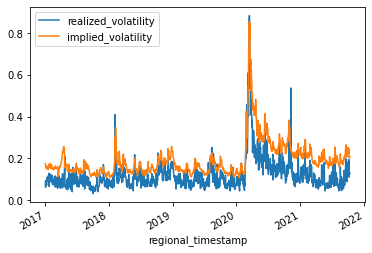

In [35]:
lines = Volatility_combined.plot.line()

Bingo ! Same scale and we see where we would expect realized > implied. 2018 IR hikes, 2020 covid , second wave as well

In [36]:
from statsmodels.tsa.stattools import adfuller
X = Volatility_combined["realized_volatility"]
Y = Volatility_combined["implied_volatility"]
result = adfuller(X)
result1 = adfuller(Y)
print('ADF Statistic realized, implied: %f, %g' % (result[0],result1[0]))
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic realized, implied: -5.005836, -3.99599
p-value: 0.000022
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [37]:
Volatility_combined.head(10)

,realized_volatility,implied_volatility
regional_timestamp,,
2017-01-03,0.089028,0.173519
2017-01-04,0.061330,0.164641
2017-01-05,0.093856,0.159801
2017-01-06,0.092509,0.153421
2017-01-09,0.074459,0.155143
2017-01-10,0.070969,0.153547
2017-01-11,0.107536,0.157011
2017-01-12,0.103465,0.162935
2017-01-13,0.089040,0.148618


In [38]:
Volatility_combined['difference_lagged'] = Volatility_combined['implied_volatility'].shift(21) - Volatility_combined['realized_volatility']
Volatility_combined['difference'] = Volatility_combined['implied_volatility'] - Volatility_combined['realized_volatility']
#Volatility_combined['implied_volatility'] = Volatility_combined['implied_volatility'].shift(21)

<AxesSubplot:xlabel='regional_timestamp'>

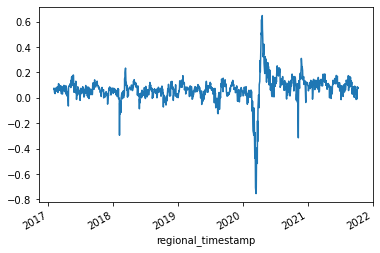

In [39]:
Volatility_combined['difference_lagged'].plot.line()

<AxesSubplot:xlabel='regional_timestamp'>

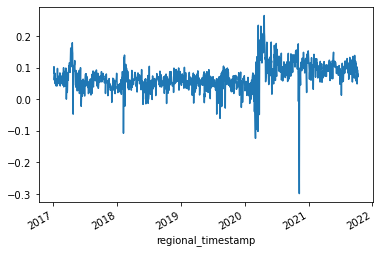

In [40]:
Volatility_combined['difference'].plot.line()

In [41]:
from statsmodels.tsa.stattools import adfuller
X = Volatility_combined['difference'][31:]
result = adfuller(X)
print('ADF Statistic realized, implied: %f' % (result[0]))
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic realized, implied: -4.316941
p-value: 0.000415
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [42]:
Volatility_combined.head(5)

,realized_volatility,implied_volatility,difference_lagged,difference
regional_timestamp,,,,
2017-01-03,0.089028,0.173519,NaN,0.084491
2017-01-04,0.061330,0.164641,NaN,0.103311
2017-01-05,0.093856,0.159801,NaN,0.065945
2017-01-06,0.092509,0.153421,NaN,0.060912
2017-01-09,0.074459,0.155143,NaN,0.080684


## Benchmark

We need a benchmark realized volatility to compare results with our calculations

In [43]:
Benchmark = pd.read_csv("Data/HistoricVola_ESX50.csv")
Benchmark['regional_timestamp'] = pd.to_datetime(Benchmark['regional_timestamp'])
Benchmark = Benchmark.rename(columns={'VOLATILITY_30D':"realized_volatility"})
Benchmark = Benchmark.set_index('regional_timestamp')
Benchmark = pd.concat([Benchmark, VSTOXX1], axis=1)
Benchmark['Preis_Norm'] = Benchmark['Preis_Norm'].transform(lambda x : x/100)
Benchmark['realized_volatility'] = Benchmark['realized_volatility']#.transform(lambda x : x/100)
Benchmark = Benchmark.rename(columns = {"Preis_Norm":"implied_volatility"})
Benchmark['realized_volatility'] = Benchmark['realized_volatility'] / np.sqrt(252)

In [44]:
Benchmark.head()

,realized_volatility,implied_volatility
regional_timestamp,,
2017-01-03,0.686635,0.173519
2017-01-04,0.674667,0.164641
2017-01-05,0.677186,0.159801
2017-01-06,0.677816,0.153421
2017-01-09,0.640020,0.155143


In [45]:
Benchmark['difference_lagged'] = Benchmark['implied_volatility'].shift(21) - Benchmark['realized_volatility']
Benchmark['difference'] = Benchmark['implied_volatility'] - Benchmark['realized_volatility']

<AxesSubplot:xlabel='regional_timestamp'>

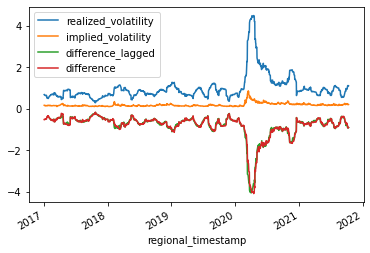

In [46]:
Benchmark.plot.line()

<AxesSubplot:xlabel='regional_timestamp'>

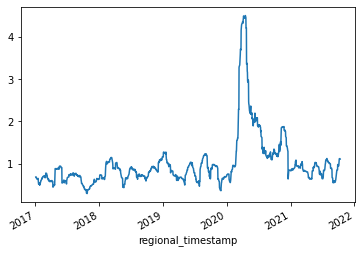

In [47]:
Benchmark['realized_volatility'].plot.line()

<AxesSubplot:xlabel='regional_timestamp'>

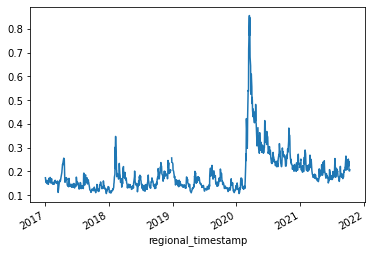

In [48]:
Benchmark['implied_volatility'].plot.line()

<AxesSubplot:xlabel='regional_timestamp'>

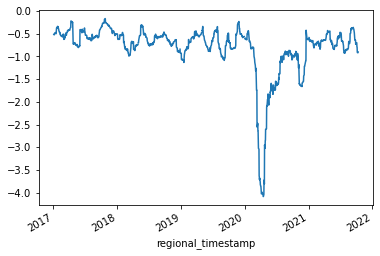

In [49]:
Benchmark['difference'].plot.line()

<AxesSubplot:xlabel='regional_timestamp'>

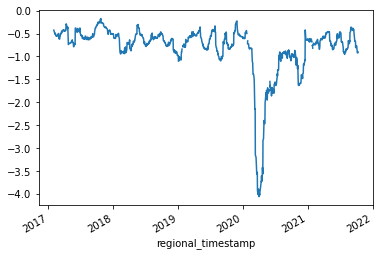

In [50]:
Benchmark['difference_lagged'].plot.line()

In [51]:
pd.notnull(Benchmark).value_counts()

realized_volatility  implied_volatility  difference_lagged  difference
True                 True                True               True          1184
                                         False              True            31
                     False               True               False           10
dtype: int64

## Saving the Csvs

In [52]:
# Saving for use in other notebook
############################
Volatility_combined.to_csv('Volatility.csv')
############################
Benchmark.to_csv('Benchmark.csv')
############################
